## Data Preprocessing

In [1]:
# Necessary imports for data handling, visualization, and machine learning
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import requests
from io import StringIO
from matplotlib.gridspec import GridSpec
import random
import concurrent.futures
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Web Scraping
The scraping section of the notebook is designed to download and prepare football data for analysis. This involves automatically fetching match results, player statistics, and other relevant data from the web. The process is automated using Python scripts, which scrape data from specified sources, then clean and organize this data into a structured format suitable for analysis. This section includes code to check for existing data directories, create new ones if necessary, and handle web requests to download the data. It's essential for ensuring the dataset is up-to-date and comprehensive, covering various leagues and seasons as needed.

In [2]:
### THIS PART OF THE CODE WAS GIVEN TO ME. I JUST ADDED extended_to_keep
Downloading_Option=0 #1 for using webscrapign to download the data, 0 for using saved data
if Downloading_Option:
    

    def parse_date(date_str):
        date_formats = ['%d/%m/%Y', '%d/%m/%y']
        for fmt in date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                pass
        return None


    # Create a dictionary dict_countries similar to the one we used in the scraping section
    dict_countries = {
        "Spanish La Liga": "SP1", "Spanish Segunda Division": "SP2", "German Bundesliga": "D1", "German Bundesliga 2": "D2",
        "Italian Serie A": "I1", "Italian Serie B": "I2", "English Premier League": "E0", "English Championship": "E1", "English League 1": "E2",
        "English League 2": "E3", "French Ligue 1": "F1", "French Ligue 2": "F2", "Dutch Eredivisie": "N1",
        "Belgian First Division A": "B1", "Portuguese Primeira Liga": "P1", "Turkish Super League": "T1", "Greek Super League": "G1",
        "Scottish Premier League": "SC0", "Scottish League1": "SC1", "Scottish League2": "SC2", "Scottish League3": "SC3"
    }

    # Create a dictionary to store the downloaded dataframes
    dict_historical_data = {}



    # Define the list of columns to keep
    to_keep = ['Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
               'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 
               'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 
               'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 
               'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA']


    # Function to download data for a specific league and year
    def download_data(league, year):
        s_year = int(str(year)[-2:])
        url = f"https://www.football-data.co.uk/mmz4281/{s_year}{(s_year + 1):02d}/{dict_countries[league]}.csv"
        try:
            response = requests.get(url)
            response.raise_for_status()  # Check for HTTP errors
            csv_data = StringIO(response.text)
            df = pd.read_csv(csv_data)
            df['Season'] = f"{year}-{year + 1}"
            return df
        except Exception as e:
            print(f"Failed to download data for {league} - {year}: {e}")
            return None

    # Download data in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(download_data, league, year) for league in dict_countries for year in range(2020, 2024)]

        # Track the progress of the downloads using a tqdm progress bar
        with tqdm(total=len(futures), unit='file', desc='Downloading historical data') as pbar:
            for future in futures:
                df = future.result()
                if df is not None:
                    league = df['Div'].iloc[0]
                    if league not in dict_historical_data:
                        dict_historical_data[league] = []
                    dict_historical_data[league].append(df)
                pbar.update(1)

    # Concatenate the DataFrames for each league
    for league in dict_historical_data:
        combined_df = pd.concat(dict_historical_data[league], ignore_index=True)

        # Select the specified columns in the combined dataframe
        combined_df = combined_df[to_keep]

        dict_historical_data[league] = combined_df
        
        all_data_frames = []

    # Process each league's DataFrame to add a 'League' column and collect them
    for league, df in dict_historical_data.items():
        df['League'] = league  # Add a league identifier column
        all_data_frames.append(df)

    # Combine all league DataFrames into a single DataFrame for analysis
    matches_df = pd.concat(all_data_frames, ignore_index=True)

    # Data Preparation for Analysis

    # Define the size of the subsample for analysis; -1 indicates using the full dataset
    subsample_size = -1

    # Convert 'Date' column to datetime format and sort the DataFrame by date
    matches_df['Date'] = pd.to_datetime(matches_df['Date'], dayfirst=True)
    matches_df.sort_values('Date', inplace=True)


    # Function to calculate points
    def calculate_points(result):
        if result == 'H':
            return 3, 0
        elif result == 'A':
            return 0, 3
        return 1, 1

    # Subset Creation for Model Training or Analysis

    # Create a subset of the matches DataFrame based on the defined subsample size
    if subsample_size > 0:
        subset_df = matches_df.sample(n=subsample_size, random_state=42)
    else:
        subset_df = matches_df.copy()

    # Ensure the 'Date' column in the subset is in datetime format and sort by date
    subset_df['Date'] = pd.to_datetime(subset_df['Date'], dayfirst=True)
    subset_df.sort_values('Date', inplace=True)
    
    all_data_frames = []

    # Process each league's DataFrame to add a 'League' column and collect them
    for league, df in dict_historical_data.items():
        df['League'] = league  # Add a league identifier column
        all_data_frames.append(df)

    # Combine all league DataFrames into a single DataFrame for analysis
    matches_df = pd.concat(all_data_frames, ignore_index=True)

    # Data Preparation for Analysis

    # Define the size of the subsample for analysis; -1 indicates using the full dataset
    subsample_size = -1

    # Convert 'Date' column to datetime format and sort the DataFrame by date
    matches_df['Date'] = pd.to_datetime(matches_df['Date'], dayfirst=True)
    matches_df.sort_values('Date', inplace=True)


    # Function to calculate points
    def calculate_points(result):
        if result == 'H':
            return 3, 0
        elif result == 'A':
            return 0, 3
        return 1, 1

    # Subset Creation for Model Training or Analysis

    # Create a subset of the matches DataFrame based on the defined subsample size
    if subsample_size > 0:
        subset_df = matches_df.sample(n=subsample_size, random_state=42)
    else:
        subset_df = matches_df.copy()

    # Ensure the 'Date' column in the subset is in datetime format and sort by date
    subset_df['Date'] = pd.to_datetime(subset_df['Date'], dayfirst=True)
    subset_df.sort_values('Date', inplace=True)
    
    df=subset_df



# Function to determine the country based on the dictionaries
def get_country(div):
    for country, divisions in dict_countries.items():
        if div in divisions:
            return country
    for country, abbreviation in dict_others.items():
        if div == abbreviation:
            return country
    return ''

In [3]:
if not Downloading_Option:
    # Importing the dataset and adjusting it according to our needs
    # Dictionaries
    # Create a dictionary dict_countries similar to the one we used in the scraping section
    dict_countries = {
            "Spanish La Liga": "SP1", "Spanish Segunda Division": "SP2", "German Bundesliga": "D1", "German Bundesliga 2": "D2",
            "Italian Serie A": "I1", "Italian Serie B": "I2", "English Premier League": "E0", "English Championship": "E1", "English League 1": "E2",
            "English League 2": "E3", "French Ligue 1": "F1", "French Ligue 2": "F2", "Dutch Eredivisie": "N1",
            "Belgian First Division A": "B1", "Portuguese Primeira Liga": "P1", "Turkish Super League": "T1", "Greek Super League": "G1",
            "Scottish Premier League": "SC0", "Scottish League1": "SC1", "Scottish League2": "SC2", "Scottish League3": "SC3"
        }

    dict_others = {
        "Argentina": "ARG", "Austria": "AUT", "Brazil": "BRA", "China": "CHN",
        "Denmark": "DNK", "Finland": "FIN", "Ireland": "IRL", "Japan": "JPN",
        "Mexico": "MEX", "Norway": "NOR", "Poland": "POL", "Romania": "ROM",
        "Russia": "RUS", "Sweden": "SWE", "Switzerland": "SWZ", "USA": "USA"
    }



    df = pd.read_csv("football_data.csv")
    df['Country'] = df['Div'].apply(get_country)
    df.drop("Unnamed: 0", axis=1, inplace=True)

    # Convert 'Date' to datetime format and format it to DD/MM/YYYY
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%d/%m/%Y')

    # Select relevant columns
    columns_to_keep = ['Country', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
                       'HTHG', 'HTAG', 'HTR', 'HC', 'AC', 'B365H', 'B365A', 'B365D']
    df = df[columns_to_keep].dropna(subset=['Date'])

    # Create 'Season' column
    df['Season'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce').dt.year
    df['Season'] = df['Season'].apply(lambda season: f"{int(season)}/{int(season) + 1}" if not pd.isna(season) else np.nan)

df.tail()


,Country,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HC,AC,B365H,B365A,B365D,Season
114770,,Premier Division,02/03/2012,Monaghan,Dundalk,0.0,0.0,D,0.0,0.0,0,0.0,0.0,2.78,2.92,3.10,2012/2013
114771,,Premier Division,02/03/2012,Drogheda,Shamrock Rovers,1.0,2.0,A,0.0,0.0,0,0.0,0.0,11.63,1.34,5.16,2012/2013
114772,,Premier Division,02/03/2012,Shelbourne,Sligo Rovers,1.0,1.0,D,0.0,0.0,0,0.0,0.0,4.01,2.13,3.26,2012/2013
114773,,Premier Division,02/03/2012,St. Patricks,Bray,1.0,0.0,H,0.0,0.0,0,0.0,0.0,1.54,7.34,4.21,2012/2013
114774,,Premier Division,02/03/2012,Derry City,Bohemians,1.0,0.0,H,0.0,0.0,0,0.0,0.0,1.86,5.17,3.39,2012/2013


In [4]:
# Creating a list of all the Divs and the seasons concatenated
Div = df.Div.unique()
seasons = df.Season.unique()
Div_season = []
for i in Div:
    for j in seasons:
        ls = []
        ls.append(i)
        ls.append(j)
        Div_season.append(ls)

In [5]:
# Defining a function to create the features we will need for our predictions.

def stats(season):
    #season = season.drop("Unnamed: 0", axis=1)
    teams = season["HomeTeam"].unique()
    window = 5
    nan_col = np.nan
    season["HAS"] = nan_col
    season["HDS"] = nan_col
    season["AAS"] = nan_col
    season["ADS"] = nan_col
    season["OH"] = nan_col
    season["OA"] = nan_col
    season["Over/Under"] = [1 if (j["FTHG"] + j["FTAG"])>2 else 0 for i,j in season.iterrows()]
    for i in teams:
        hometeam = season["HomeTeam"]==i
        awayteam = season["AwayTeam"]==i
        season["HAS"][hometeam] = season["FTHG"][hometeam].ewm(span=window).mean().shift(-1)
        season["HDS"][hometeam] = season["FTAG"][hometeam].ewm(span=window).mean().shift(-1)
        season["AAS"][awayteam] = season["FTAG"][awayteam].ewm(span=window).mean().shift(-1)
        season["ADS"][awayteam] = season["FTHG"][awayteam].ewm(span=window).mean().shift(-1)
        season["OH"][hometeam] = season["Over/Under"][hometeam].ewm(span=window).mean().shift(-1)
        season["OA"][awayteam] = season["Over/Under"][awayteam].ewm(span=window).mean().shift(-1)
        
    # Adding bid-related features
    season['InverseHomeWinOdds'] = 1 / season['B365H']
    season['InverseDrawOdds'] = 1 / season['B365D']
    season['InverseAwayWinOdds'] = 1 / season['B365A']

    season = season.dropna(how='all')
    return season


# Calculate recent form for Home and Away Teams (e.g., points from last 5 matches)
def calculate_recent_form(subset_df, team, date_of_match, matches=5):
    team_matches = subset_df[((subset_df['HomeTeam'] == team) | (subset_df['AwayTeam'] == team)) & (subset_df['Date'] < date_of_match)].tail(matches)
    points = 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'] == team:
            points += calculate_points(match['FTR'])[0]
        else:
            points += calculate_points(match['FTR'])[1]
    return points / matches if matches > 0 else 0

# Function to calculate points
def calculate_points(result):
    if result == 'H':
        return 3, 0
    elif result == 'A':
        return 0, 3
    return 1, 1


In [6]:
# Applying the previous function to all the datasets previously scraped
df_merge=[]
for i in Div_season:
    try:
        df_tomerge = df[(df["Div"] == i[0]) & (df["Season"] == i[1])]
        df_merge.append(stats(df_tomerge))
    except:
        continue
merged_df = pd.concat(df_merge)

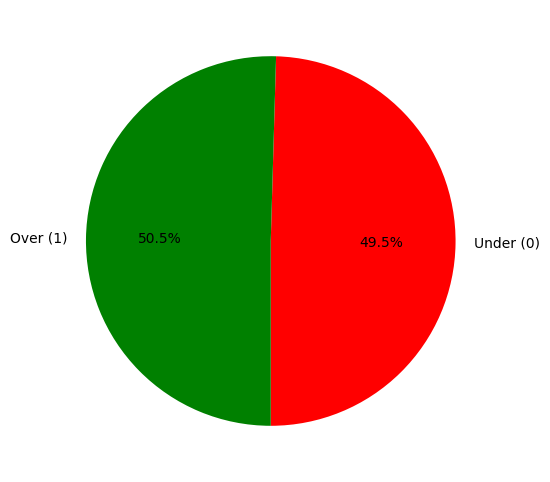

In [7]:
# Checking if there's balance among the number of under and over

labels = ["Under (0)", "Over (1)"]
under_len = len(merged_df[merged_df["Over/Under"]==0])
over_len = len(merged_df[merged_df["Over/Under"]==1])
sizes = [over_len, under_len]
colors = ["red", "green"]
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=270)
plt.show()

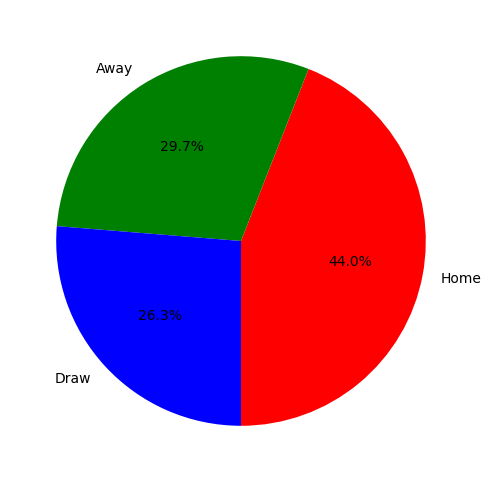

In [8]:
# Checking if there's balance among the number of Home, Away or Draw

labels = ["Home","Away", "Draw"]
home_len = len(merged_df[merged_df["FTR"]=="H"])
away_len = len(merged_df[merged_df["FTR"]=="A"])
draw_len = len(merged_df[merged_df["FTR"]=="D"])
sizes = [home_len, away_len,draw_len]
colors = ["red", "green","blue"]
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=270)
plt.show()

## Machine learning model training and evaluation
This includes defining classifiers, applying dimensionality reduction techniques,
fitting models, plotting decision boundaries, and evaluating classifier performance.

In the machine learning section, the notebook focuses on building predictive models to forecast football match outcomes. This involves several steps: preprocessing the scraped data, selecting features, splitting the dataset into training and test sets, and normalizing the data. Various machine learning algorithms are applied, such as Logistic Regression, Support Vector Machines, K-Nearest Neighbors, Decision Trees, Random Forests, Gradient Boosting, Naive Bayes, Neural Networks, and others. Each model is trained on historical data and evaluated based on its accuracy in predicting match results. This section also explores dimensionality reduction techniques like PCA and LDA to improve model performance.

In [9]:
def apply_dimensionality_reduction(method, reducer, X_train, X_test, y_train, X_combined=None, y_combined=None):
    """
    Applies the specified dimensionality reduction technique to the training and test datasets.
    Supports special handling for methods like 't-SNE' that don't support transforming new data.
    """
    # Check if the method is t-SNE due to its special handling requirements
    if method == 't-SNE':
        # Standardize the features by removing the mean and scaling to unit variance
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        # Apply t-SNE to the scaled training data
        X_train_reduced = reducer.fit_transform(X_train_scaled)
        return X_train_reduced, None
    else:
        # Handle PCA and LDA with a pipeline for scaling and reduction
        if method in ['LDA', 'PCA']:
            pipeline = make_pipeline(StandardScaler(), reducer)
            X_train_reduced = pipeline.fit_transform(X_train, y_train)
            X_test_reduced = pipeline.transform(X_test)
        else:
            # Scale training and test sets for other methods
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_train_reduced = reducer.fit_transform(X_train_scaled, y_train)
            try:
                # Attempt to transform the test set using the reducer
                X_test_reduced = reducer.transform(X_test_scaled)
            except AttributeError:
                # Handle reducers that do not support transforming new data
                print(f"{method} does not support transforming new data. Applying on all data...")
                if X_combined is not None and y_combined is not None:
                    # Use combined data for fitting and then split for training and test sets
                    X_reduced = reducer.fit_transform(X_combined, y_combined)
                    split_point = X_train.shape[0]
                    X_train_reduced, X_test_reduced = X_reduced[:split_point, :], X_reduced[split_point:, :]
                else:
                    # Apply the reducer to the scaled training data only
                    X_reduced = reducer.fit_transform(X_train_scaled, y_train)
                    X_train_reduced, X_test_reduced = X_reduced, None
        return X_train_reduced, X_test_reduced, pipeline

def fit_and_plot_classifier(clf, X_train, y_train, X_test, y_test, ax, title, method):
    """
    Fits the classifier, predicts on the test set, and plots decision boundaries and accuracy.
    """
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    # Predict on the test set if it exists
    y_pred = clf.predict(X_test) if X_test is not None else None
    
    # Generate mesh grid for decision boundary visualization
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    # Plot decision boundaries if predictions were made
    if y_pred is not None:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.4)
    
    # Plot training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', cmap='viridis')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    
    # Calculate and display accuracy if test set predictions were made
    if y_pred is not None:
        accuracy = accuracy_score(y_test, y_pred)
        ax.set_xlabel(f"Accuracy: {accuracy:.2f}")
    return clf, accuracy

def evaluate_and_plot_classifiers(data_ftr, data_ou, classifiers, dimensionality_reductions_ftr, dimensionality_reductions_ou, title_suffix=''):
    """
    Evaluates classifiers with different dimensionality reduction techniques and plots results.
    Identifies the best performing classifier and method for both feature types.
    """
    # Split feature and outcome datasets into training and test sets
    X_train_ftr, X_test_ftr, y_train_ftr, y_test_ftr = data_ftr
    X_train_ou, X_test_ou, y_train_ou, y_test_ou = data_ou
    
    # Initialize figure for plotting
    fig = plt.figure(figsize=(24, 12 * len(dimensionality_reductions_ftr)))  # Adjust the second number to increase vertical size
    
    # Define a GridSpec for subplot arrangement with appropriate spacing
    gs = GridSpec(2 * len(dimensionality_reductions_ftr), len(classifiers), figure=fig, hspace=0.4)  # Adjust hspace for vertical spacing
    
    # Initialize variables to track the best classifier and score for both feature types
    best_score_ftr = 0
    best_clf_ftr = None
    pca_ftr = None
    best_method_ftr = ""
    best_score_ou = 0
    best_clf_ou = None
    pca_ou = None
    best_method_ou = ""
    
    # Apply tight layout to adjust subplots to fit into the figure area
    plt.tight_layout()
    # Adjust the top and wspace for subplot adjustments
    plt.subplots_adjust(top=0.80, wspace=0.3)
    
    # Loop through each dimensionality reduction technique for feature types
    for i, (method, reducer) in enumerate(dimensionality_reductions_ftr.items()):
        # Process and apply dimensionality reduction for Full Time Result (FTR) prediction
        print(f"Processing {method} for FTR prediction...")
        X_train_reduced_ftr, X_test_reduced_ftr, pca_ftr = apply_dimensionality_reduction(method, reducer, X_train_ftr, X_test_ftr, y_train_ftr)
        
        # Process and apply dimensionality reduction for Over/Under 2.5 goals prediction
        method_ou, reducer_ou = list(dimensionality_reductions_ou.items())[i]
        print(f"Processing {method_ou} for Over/Under 2.5 goals prediction...")
        X_train_reduced_ou, X_test_reduced_ou, pca_ou = apply_dimensionality_reduction(method_ou, reducer_ou, X_train_ou, X_test_ou, y_train_ou)
        
        # Evaluate classifiers for both FTR and Over/Under predictions
        for j, clf in enumerate(classifiers):
            ax_ftr = fig.add_subplot(gs[i * 2, j])
            clf_ftr, score_ftr = fit_and_plot_classifier(clf, X_train_reduced_ftr, y_train_ftr, X_test_reduced_ftr, y_test_ftr, ax_ftr, f"FTR - {clf.__class__.__name__} ", method)
            
            # Update best classifier and score for FTR if current score is higher
            if score_ftr > best_score_ftr:
                best_score_ftr = score_ftr
                best_clf_ftr = clf_ftr
                best_method_ftr = method
                
            ax_ou = fig.add_subplot(gs[i * 2 + 1, j])
            clf_ou, score_ou = fit_and_plot_classifier(clf, X_train_reduced_ou, y_train_ou, X_test_reduced_ou, y_test_ou, ax_ou, f"OU - {clf.__class__.__name__}", method)
            
            # Update best classifier and score for Over/Under if current score is higher
            if score_ou > best_score_ou:
                best_score_ou = score_ou
                best_clf_ou = clf_ou
                best_method_ou = method
    
    # Adjust layout to ensure everything fits without overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    # Save the figure with a random filename to avoid overwriting
    random_number = random.randint(1000, 9999)
    fig.savefig(f'./model_comparison_{random_number}.png')  # Adjust the path and filename as needed
    
    # Show the figure in the notebook
    plt.show()
    
    # Return the best classifiers and their corresponding methods for both feature types
    return best_clf_ftr, best_method_ftr, best_clf_ou, best_method_ou, pca_ftr, pca_ou


Processing PCA for FTR prediction...
Processing PCA for Over/Under 2.5 goals prediction...


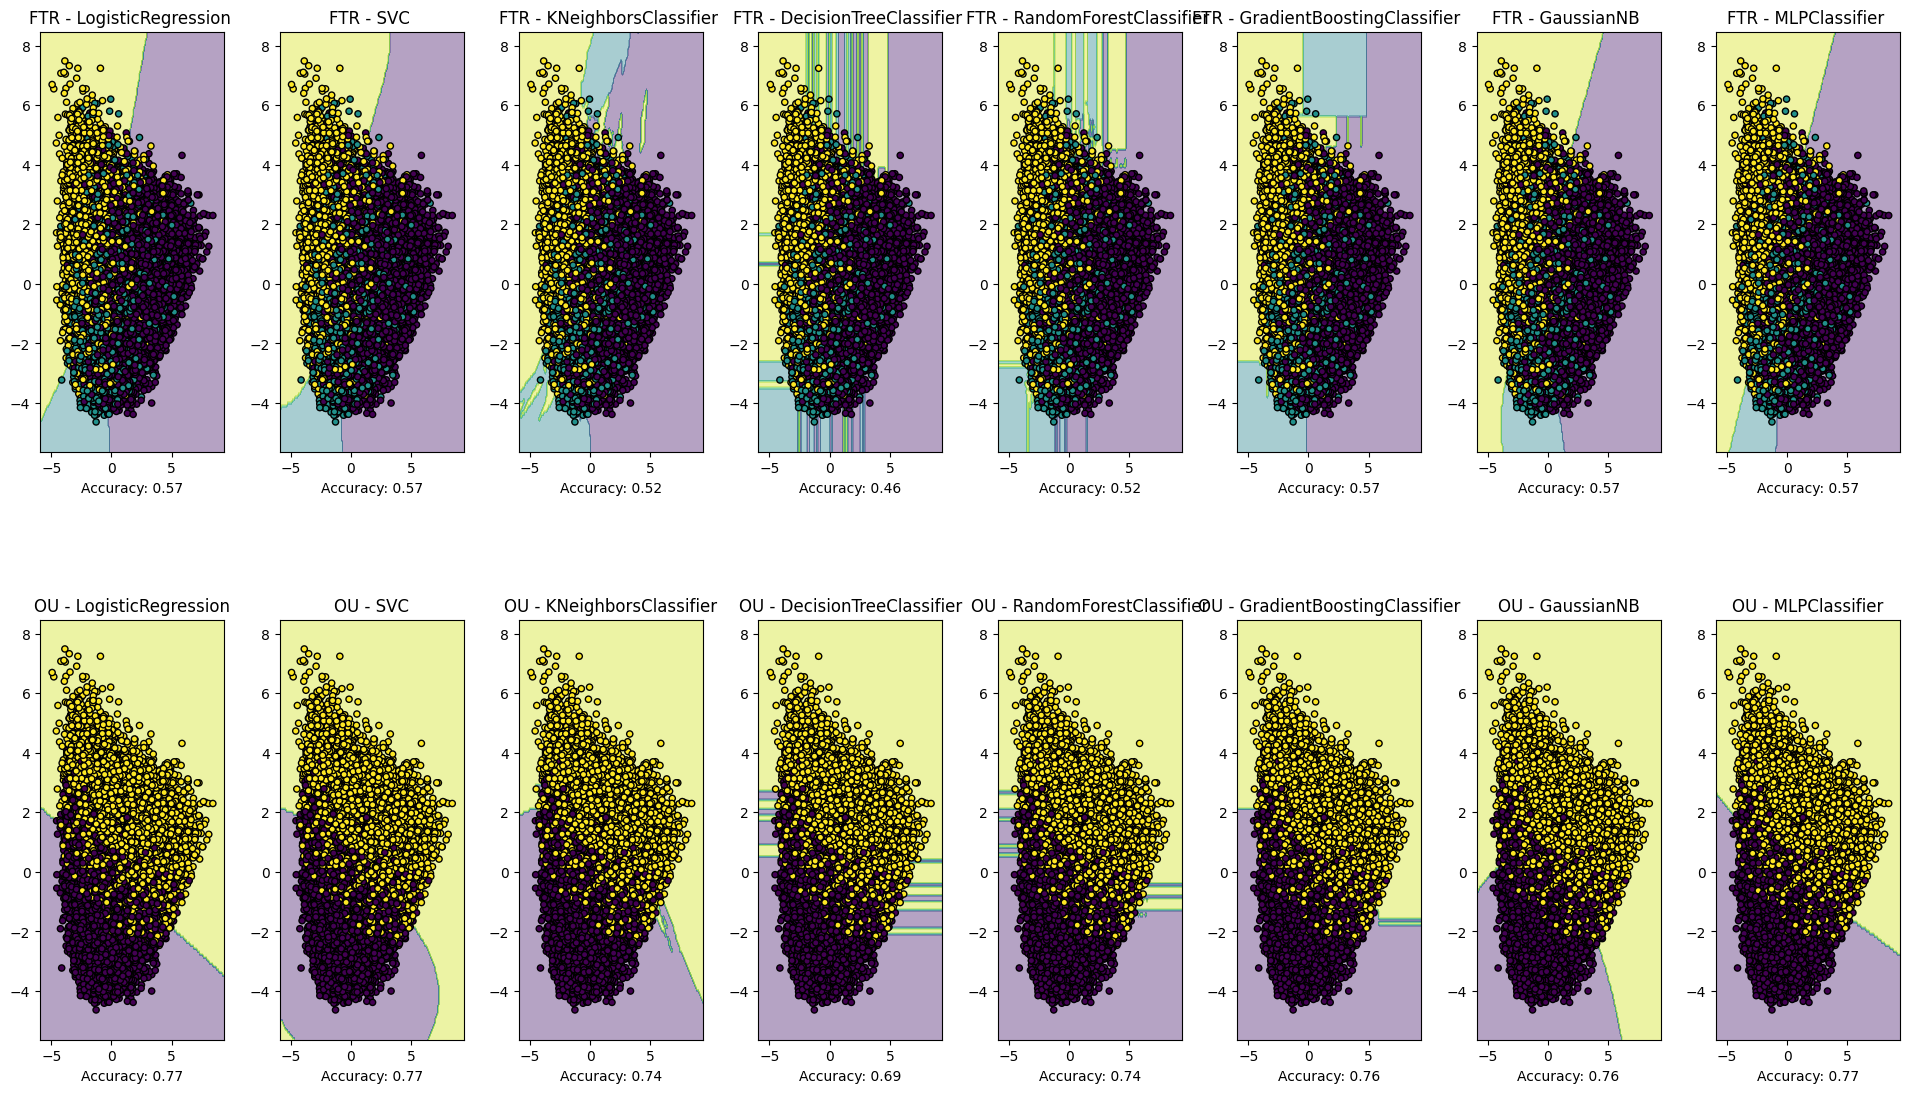

Processing PCA for FTR prediction...
Processing PCA for Over/Under 2.5 goals prediction...


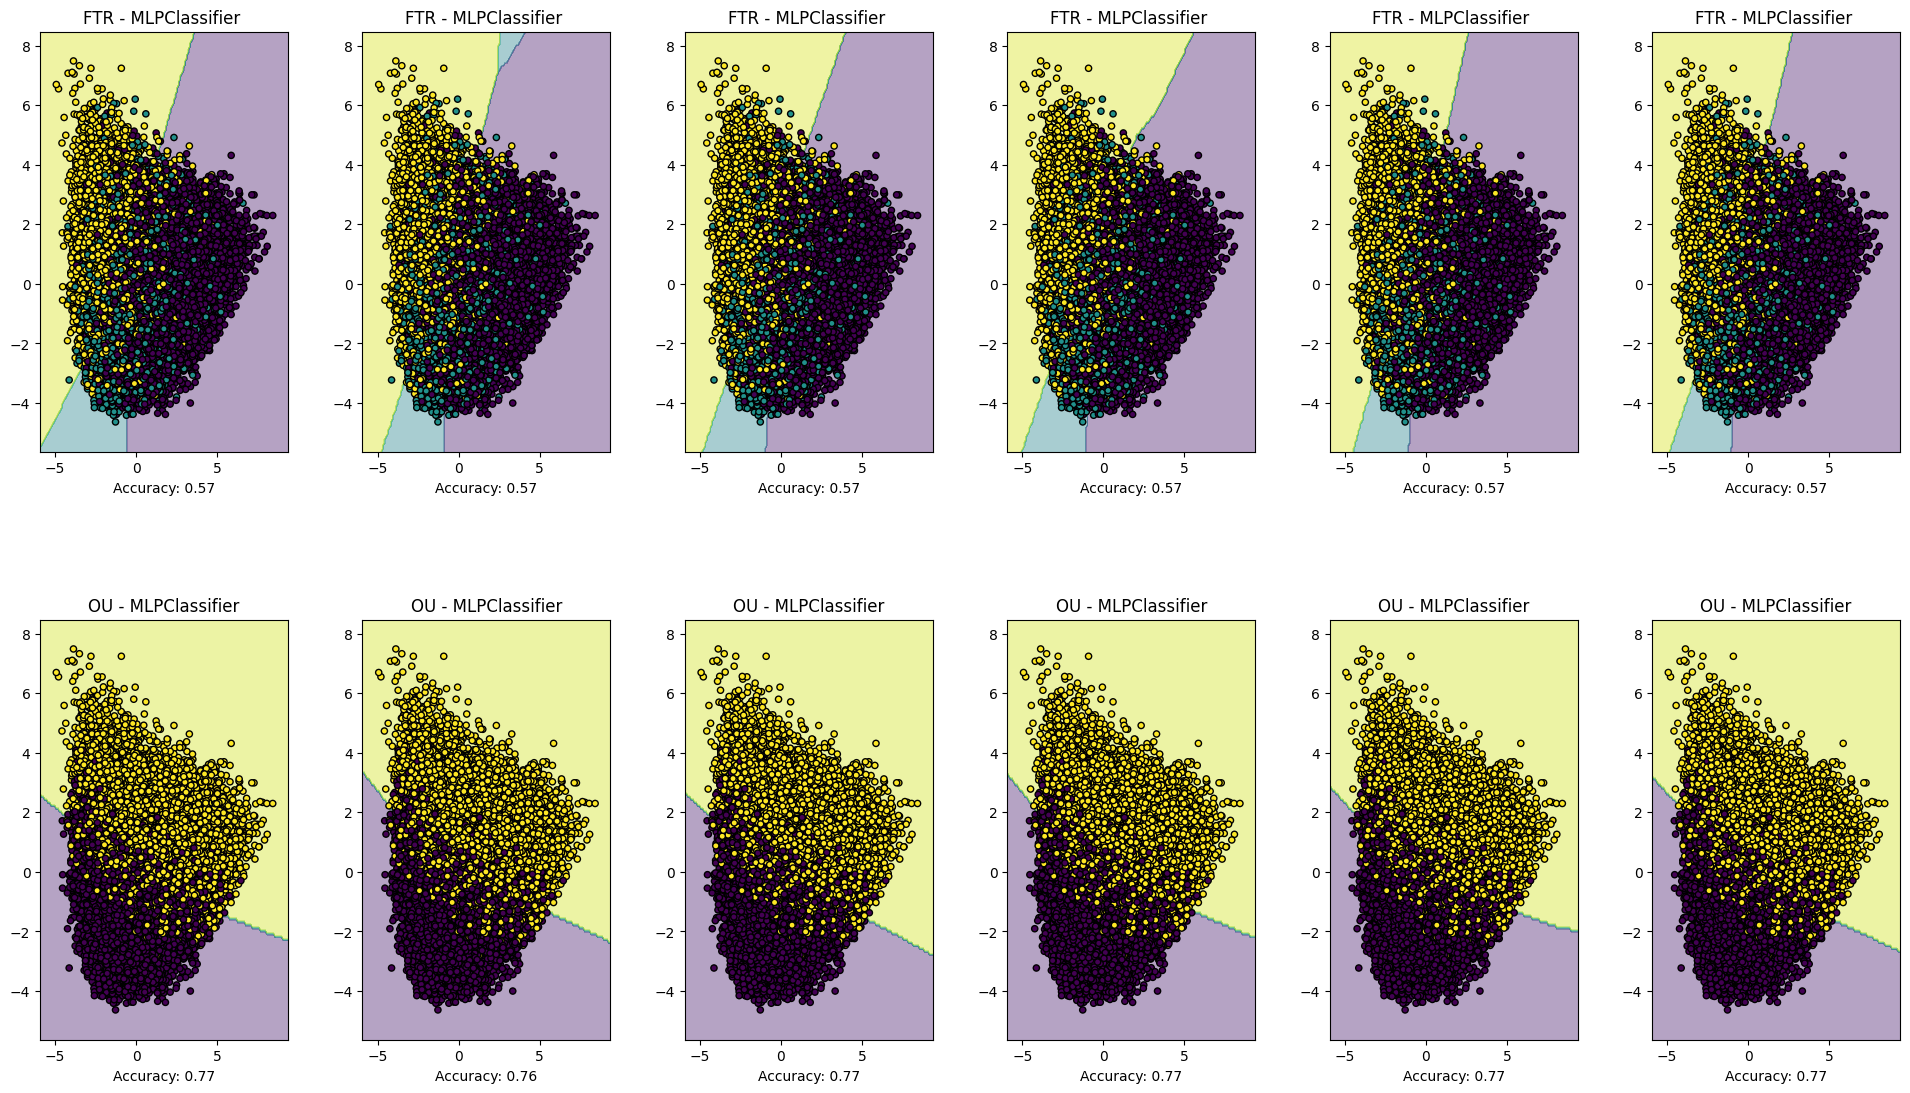

In [10]:
# Define dimensionality reduction techniques with key-value pairs, 
# where the key is the name of the method and the value is an instance of the method with specified parameters.
dimensionality_reductions_ftr = {
    "PCA": PCA(n_components=2)  # Principal Component Analysis with 2 components for dimensionality reduction.
    # Uncomment the lines below for exploring additional dimensionality reduction techniques.
    #"LDA": LDA(n_components=2),  # Linear Discriminant Analysis with 2 components.
    #"t-SNE": TSNE(n_components=2, random_state=42, init='pca'),  # t-SNE for visualization with specified parameters.
    #"Isomap": Isomap(n_components=2),  # Isomap for non-linear dimensionality reduction.
    #"MDS": MDS(n_components=2, random_state=42),  # Multi-Dimensional Scaling.
    #"Spectral Embedding": SpectralEmbedding(n_components=2),  # Spectral Embedding for non-linear dimensionality reduction.
    #"UMAP": umap.UMAP(n_components=2, random_state=42)  # Uniform Manifold Approximation and Projection.
}

dimensionality_reductions_ou = {
    "PCA": PCA(n_components=2)  # PCA for dimensionality reduction, applicable for Over/Under 2.5 goals prediction.
    # More methods can be added and explored as commented above.
}

# Initialize classifiers for model training, each with specific configurations for reproducibility and optimization.
classifiers_original = [
    LogisticRegression(random_state=42),  # Logistic Regression for baseline comparison.
    SVC(random_state=42),  # Support Vector Classifier with default kernel for margin maximization.
    KNeighborsClassifier(),  # K-Nearest Neighbors for instance-based learning.
    DecisionTreeClassifier(random_state=42),  # Decision Tree for hierarchical decision making.
    RandomForestClassifier(random_state=42),  # Random Forest for ensemble of decision trees.
    GradientBoostingClassifier(random_state=42),  # Gradient Boosting for sequential improvement of models.
    GaussianNB(),  # Gaussian Naive Bayes for assumption of normal distribution in features.
    MLPClassifier(random_state=42, max_iter=1000)  # Multi-Layer Perceptron for neural network-based classification.
]

# Define MLPClassifiers with various configurations to test different neural network architectures.
classifiers_mlp = [
    MLPClassifier(hidden_layer_sizes=(10,), random_state=42, max_iter=1000),  # Single hidden layer with 10 neurons.
    MLPClassifier(hidden_layer_sizes=(50,), random_state=42, max_iter=1000),  # Single hidden layer with 50 neurons.
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=1000),  # Single hidden layer with 100 neurons.
    MLPClassifier(hidden_layer_sizes=(10, 10), random_state=42, max_iter=1000),  # Two hidden layers with 10 neurons each.
    MLPClassifier(hidden_layer_sizes=(50, 10), random_state=42, max_iter=1000),  # Two hidden layers with 50 and 10 neurons.
    MLPClassifier(hidden_layer_sizes=(20, 5), random_state=42, max_iter=1000)  # Two hidden layers with 20 and 5 neurons.
]

# Data cleaning and preparation steps, including dropping missing values and handling infinite values in feature sets.
merged_df2=merged_df.dropna()  # Drop rows with any NaN values.
# Feature sets for Full-Time Result (FTR) and Over/Under (OU) predictions.
X_ftr = merged_df2[["HAS", "HDS", "AAS", "ADS", "OH", "OA" , 'InverseHomeWinOdds', 'InverseDrawOdds', 'InverseAwayWinOdds']]
X_ou=merged_df2[["HAS", "HDS", "AAS", "ADS", "OH", "OA" , 'InverseHomeWinOdds', 'InverseDrawOdds', 'InverseAwayWinOdds']]

# Mapping and cleaning target variables for FTR and Over/Under predictions.
y_ftr = merged_df2['FTR'].map({'H': 0, 'D': 1, 'A': 2})
y_over_under = merged_df2["Over/Under"]

# Remove infinite values from feature and target datasets to ensure model compatibility.
infinite_mask = np.isinf(X_ftr.values).any(axis=1)
X_ftr = X_ftr[~infinite_mask]
y_ftr = y_ftr[~infinite_mask]

infinite_mask = np.isinf(X_ou.values).any(axis=1)
X_ou = X_ou[~infinite_mask]
y_over_under = y_over_under[~infinite_mask]

# Split the datasets for training and testing purposes for both prediction tasks.
# Split dataset for Full-Time Result (FTR) prediction.
data_ftr = train_test_split(X_ftr, y_ftr, test_size=0.2, random_state=42)
# Split dataset for Over/Under 2.5 goals prediction.
data_ou = train_test_split(X_ou, y_over_under, test_size=0.2, random_state=42)

# Evaluate classifiers with the original set and MLP variants using the defined dimensionality reduction techniques.
# Evaluation for Full-Time Result (FTR) and Over/Under (OU) prediction with original classifiers.
best_clf_ftr,best_method_ftr_clf,best_clf_ou,best_method_ou_clf,pca_ftr,pca_ou=evaluate_and_plot_classifiers(data_ftr,data_ou,classifiers_original, dimensionality_reductions_ftr, dimensionality_reductions_ou, title_suffix=' - Original Classifiers')
# Evaluation for Full-Time Result (FTR) and Over/Under (OU) prediction with MLP classifier variants.
best_mlp_ftr,best_method_ftr_mlp,best_mlp_ou,best_method_ou_mlp,pca_ftr,pca_ou=evaluate_and_plot_classifiers(data_ftr,data_ou,classifiers_mlp, dimensionality_reductions_ftr, dimensionality_reductions_ou, title_suffix=' - MLP Variants')


# Applying trained models to new data
Generating predictions for match outcomes and over/under scores,
then appending these predictions along with their probabilities to the fixture data.

The future prediction section utilizes the trained models to make predictions on upcoming football matches. This involves applying the predictive models to new data—typically the latest fixtures not included in the training dataset—to forecast outcomes such as win, lose, or draw, and other betting-relevant predictions like over/under scores. The predictions, along with their probabilities, are then appended to the fixture data. This section is crucial for translating the analytical insights gained from the machine learning models into actionable predictions that can be used for sports betting, fantasy football, or general interest in football match outcomes.


In [24]:
# Fetching fixture data from online sources for European leagues and other leagues using Pandas read_csv method.
fix_eu = pd.read_csv("https://www.football-data.co.uk/fixtures.csv")[['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A','B365<2.5' ,'B365>2.5']]
fix_other = pd.read_csv("https://www.football-data.co.uk/new_league_fixtures.csv")

# Renaming columns of the fixtures dataframe to maintain consistency and ease of understanding.
fix_other = fix_other.rename(columns={
        "League": "Div", "Home": "HomeTeam", "Away": "AwayTeam", "HG": "FTHG", "AG": "FTAG", "Res": "FTR", "PH": "B365H", "PD": "B365D", "PA": "B365A"})[['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A']]

# Combining fixtures data from both sources and preprocessing.
fixtures = pd.concat([fix_eu, fix_other], ignore_index=True).dropna(how='all').head(5)  # Concatenate and clean the data
fixtures['Country'] = ''  # Initialize a new column for the country
fixtures['Country'] = fixtures['Div'].apply(get_country)  # Apply a function to determine the country based on division

# Preparing the fixture data by initializing match-related columns with NaN and restructuring the dataframe.
fixtures[['FTR', 'HTHG',  'HTAG', 'HTR', 'HC', 'AC', 'FTHG', 'FTAG']]=np.nan
fixtures = fixtures[['Country', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR','HTHG', 'HTAG', 'HTR', 'HC', 'AC', 'B365H', 'B365A', 'B365D']]

# Processing date information to determine the season for each fixture.
fixtures['Season'] = pd.to_datetime(fixtures['Date'], format='%d/%m/%y', errors='coerce')
fixtures['Season'] = fixtures['Season'].dt.year
fixtures['Season'] = fixtures.apply(lambda row: f"{int(row['Season'])}/{int(row['Season']) + 1}" if not pd.isna(row['Season']) else '2023/2024', axis=1)

# Filtering data for a specific division and season for feature computation.
previous_seas=df[(df["Div"] == fixtures["Div"][0]) & (df["Season"] == "2023/2024")]  # Filter for division (of fixtures) and season 2023-2024
newseas = pd.concat([fixtures, previous_seas ], ignore_index=False)  # Combine fixture data with historical data

# Compute features for the new season fixtures using predefined statistics function.
X=stats(newseas).head(len(fixtures))[["HAS", "HDS", "AAS", "ADS", "OH", "OA" , 'InverseHomeWinOdds', 'InverseDrawOdds', 'InverseAwayWinOdds']]

# Function definitions for mapping numerical prediction results to categorical outcomes.
def map_values(value):
    mapping = {0: "H", 1: 'D', 2: 'A'}  # Mapping for match results
    return mapping.get(value, "Unknown")  # Return mapped value or 'Unknown'

vectorized_map = np.vectorize(map_values)  # Vectorize the mapping

# Function to map numerical prediction results to a more understandable categorical outcome for Over/Under predictions.
def map_values_2(value):
    # Define your mapping for Over/Under predictions.
    mapping = {0: "No", 1: 'Yes'}
    return mapping.get(value, "Unknown")  # Return the categorical outcome based on the prediction or "Unknown" if not defined.

# Apply vectorization to the mapping function to handle array inputs efficiently.
vectorized_map_2 = np.vectorize(map_values_2)

# Apply the FTR model predictions and map numerical outcomes to categorical ('H', 'D', 'A').
fixtures["FTR"] = vectorized_map(best_mlp_ftr.predict(pca_ftr.transform(X.dropna())))

# Apply the Over/Under model predictions and map numerical outcomes to categorical ('Yes', 'No').
fixtures["Over/Under"] = vectorized_map_2(best_mlp_ou.predict(pca_ou.transform(X.dropna())))

# Calculate and store the probability of the predicted FTR outcome.
fixtures["FTR probability"] = [np.max(i) for i in (best_mlp_ftr.predict_proba(pca_ftr.transform(X.dropna())))]

# Calculate and store the probability of the predicted Over/Under outcome.
fixtures["Over/Under probability"] = [np.max(i) for i in (best_mlp_ou.predict_proba(pca_ou.transform(X.dropna())))]

# Select and display relevant columns for an overview of the predictions and their probabilities.
fixtures[['Country', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTR probability', 'Over/Under', 'Over/Under probability']]


,Country,Div,Date,HomeTeam,AwayTeam,FTR,FTR probability,Over/Under,Over/Under probability
0,Belgian First Division A,B1,01/03/2024,Westerlo,Charleroi,H,0.947445,No,0.934011
1,Belgian First Division A,B1,02/03/2024,Cercle Brugge,Mechelen,D,0.736031,Yes,0.736883
2,Belgian First Division A,B1,02/03/2024,Oud-Heverlee Leuven,St. Gilloise,H,0.643921,No,0.657676
3,Belgian First Division A,B1,02/03/2024,Standard,Gent,H,0.993013,No,0.991115
4,Belgian First Division A,B1,03/03/2024,Genk,Club Brugge,D,0.989625,Yes,0.987376
